# Movie genres 
## Baseline 2: TFIDF & LogisticRegressin

In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

## Загружаем данные

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission_most_popular.csv')

## Работаем с обучающей выборкой

In [3]:
# Применяем к обучающей выборке tf-idf преобразование

vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(train.dialogue)
X.shape

(36991, 10730)

## Преобразовываем вектор ответов к виуду multilabel

In [4]:
mlb = MultiLabelBinarizer()

# вектор ответов у нас в формате строка. Чтобы "выполнить" строку и получить список, нам понадобится функция eval

train.genres = train.genres.apply(eval)

# создаем объект pandas DataFrame: данные - результат преобразования MultiLabelBinarizer, названия столбцов - жанры

y = pd.DataFrame(mlb.fit_transform(train.genres), columns=mlb.classes_)

y.head()

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Оценим качество

In [5]:
# Разбиваем выборку для валидации (holdout)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Здесь мы будем использовать sklearn.multiclass.OneVsRestClassifier, который позволяет реализовывать стратегию one-vs-all - обучать отдельную модель для каждого класса, где в качестве положительных примеров берутся все объекты этого класса, в качестве отрицательных - все остальные объекты. 

In [6]:
# Оценка качества

ovrc = OneVsRestClassifier(LogisticRegression(C=10), n_jobs=-1)
ovrc.fit(X_train, y_train)
preds = ovrc.predict(X_test)

f1_score(y_test, preds, average='samples')

0.6004836146997025

Логистическая регрессия может отдавать не только предсказания метки класса, но и вероятность принадлежности объекта к целевому классу. Метрика f1_score сильно зависит от трешхолда по которому мы определяем, какая вероятность достаточна, чтобы считать объект принадлежащим к целевому классу. Попробуем для каждого класса подобрать свой оптимальный трешхолд. (Параметры алгоритма также можно подбирать для каждого класса индивидуально)

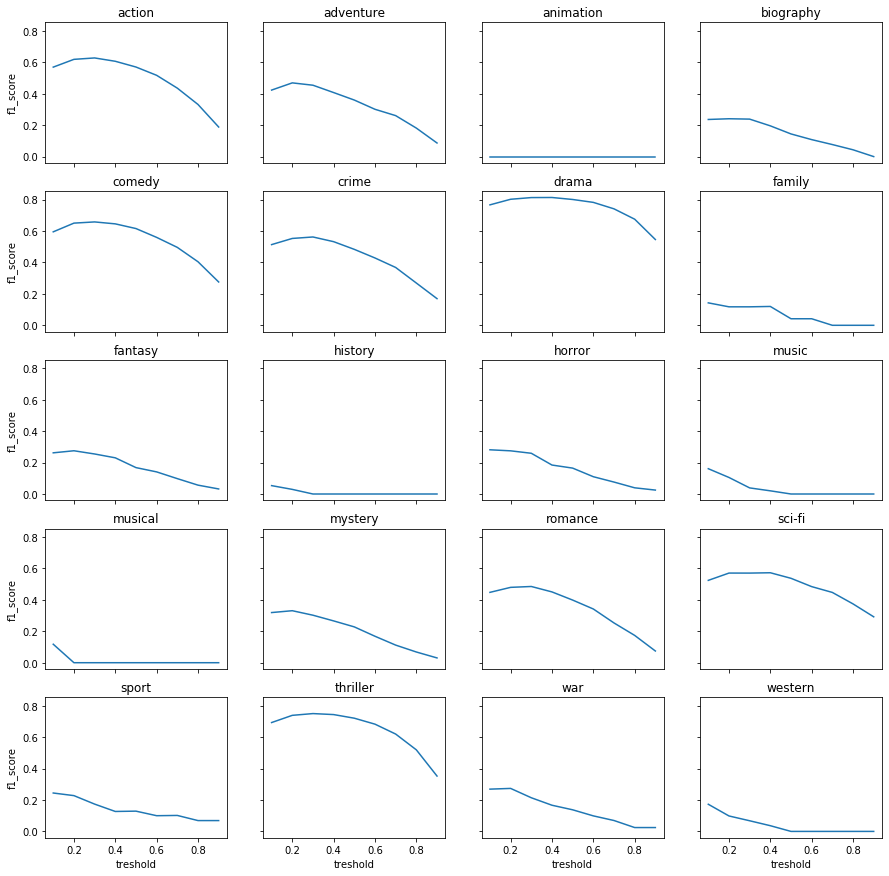

In [28]:
# объект DataFrame для хранения результатов экспериментов по подбору treshold

treshold_df = pd.DataFrame(index=y.columns, columns=['best_threshold', 'best_f1'])

# сетка возможных значений для treshold

tresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# решающий алгоритм

lr = LogisticRegression(C=10)

# для каждого класса рисуем график зависимости качества f1_score от значения treshold

f, axs = plt.subplots(5, 4, figsize = (15, 15), sharex=True, sharey=True)
for n, yi in enumerate(y.columns):
    q = [] # сюда для класса yi мы будем записывать f1_score в зависимости от значения treshold
    for tr in tresholds:
        lr.fit(X_train, y_train[yi])
        preds = lr.predict_proba(X_test)[:,1]
        q.append(f1_score(y_test[yi], preds>tr))
        
    # в соответствующей ячейке сетки рисуем график и подписываем заголовок
    
    axs.flatten()[n].plot(tresholds, q) 
    axs.flatten()[n].title.set_text(yi) 
    
    # Записываем в таблицу лучший скор и treshold который его обеспечил
    
    treshold_df.loc[yi, 'best_threshold'] = tresholds[np.argmax(q)]
    treshold_df.loc[yi, 'best_f1'] = np.max(q)
    
    # Подписываем оси только для внешних графиков
    
    if n >= 16: 
        axs.flatten()[n].set(xlabel='treshold')
    if n%4 == 0:
        axs.flatten()[n].set(ylabel='f1_score')
        

In [8]:
treshold_df

,best_treshold,best_f1
action,0.3,0.628088
adventure,0.2,0.469349
animation,0.1,0
biography,0.2,0.240964
comedy,0.3,0.658151
crime,0.3,0.562325
drama,0.4,0.8137
family,0.1,0.142857
fantasy,0.2,0.275304
history,0.1,0.0533333


In [29]:
treshold_df.to_csv('threshold.csv', index=True)

In [30]:
df = pd.read_csv('threshold.csv', index_col=0)

In [31]:
df.loc['adventure', 'best_threshold']

0.2

In [27]:
df.index[0]

'action'

In [9]:
# Оценим на валидации вклад тюнинга трешхолда в качество

ovrc = OneVsRestClassifier(LogisticRegression(C=10), n_jobs=-1)
ovrc.fit(X_train, y_train)
preds = ovrc.predict_proba(X_test)
for n, yi in enumerate(y.columns):
    preds[:, n] = preds[:, n] > treshold_df.loc[yi, 'best_treshold']

f1_score(y_test, preds, average='samples')

0.6475296815278795

In [23]:
y.columns

Index(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'musical',
       'mystery', 'romance', 'sci-fi', 'sport', 'thriller', 'war', 'western'],
      dtype='object')

## Готовим сабмит

In [10]:
# здесь мы обучаем TfidfVectorizer на объединенной выборке (train+test) - это соревноваине поэтому так можно =) 

vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(train.dialogue.append(test.dialogue))
X_train = vectorizer.transform(train.dialogue)
X_test = vectorizer.transform(test.dialogue)

y_train = y.copy()

# обучаем модель и получаем предсказания для тестовой выборки

ovrc.fit(X_train, y_train)
preds = ovrc.predict_proba(X_test)

# применяем найденные трешхолды

for n, yi in enumerate(y.columns):
    preds[:, n] = preds[:, n] > treshold_df.loc[yi, 'best_treshold']

sample_submission['genres'] = mlb.inverse_transform(preds)
sample_submission['genres'] = sample_submission['genres'] .apply(lambda x: ' '.join((x)))


In [11]:
# Заметим, что у нас есть диалоги, для которых с текущими трешхолдами не определилось ни одного жанра

sample_submission[sample_submission.genres.str.len()==0]

,id,genres
125,125,
204,204,
246,246,
270,270,
350,350,
...,...,...
8994,8994,
9146,9146,
9256,9256,
9262,9262,


In [12]:
# Заполним их самым частым жанром

sample_submission.loc[sample_submission.genres.str.len()==0, 'genres'] = 'drama'

In [13]:
sample_submission.to_csv('benchmark_2.csv', index=False)

Public 0.59939

Private 0.60053